# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics

|**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
total = 10
n1 = 8
n2 = 2
p1 = n1 / total
p2 = n2 / total
print('%.2f' %(-p1 * np.log(p1) - p2 * np.log(p2)))

0.50


Энтропия - мера неопределенности распределения. Она максимальна у равномерного распределения. Лучшее распределение - то, у которого суммарное распределение меньше. Полученное нами распределение для соотношения классов 80% и 20 % - не идеальное, но и не худшее

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
h = p1 * (1 - p1) + p2 * (1 - p2) # энтропия родительской вершины

p1l = n1 / n1 #доля объектов класса k1 в левом поддереве
p2l = 0 #доля объектов класса k2 в левом поддереве
hl = p1l * (1 - p1l) + p2l * (1 - p2l) #левого поддерева

p2r = n2 / n2 #доля объектов класса k2 в правом поддереве
p1r = 0 #доля объектов класса k1 в правом поддереве


hr = p2r * (1 - p2r) + p1r * (1 - p1r)

q = h - n1 / total * hl - n2 / total * hr
print('%.2f' %q, '- критерий информативности')
print(h, '- индекс Джини родительской вершины')

0.32 - критерий информативности
0.32 - индекс Джини родительской вершины


Таким образом, распределение по дочерним вершинам идеально, поскольку критерий информативности, записанный в данном виде, принял максимальное значение, а энтропии в дочерних вершинах приняли значения минимума (т.е. 0).

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
a = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(np.mean(a))

40.6


Для задачи регрессии в предсказании модели выдается среднее значение.

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    feature_vector, target_vector = zip(*sorted(zip(np.array(feature_vector), np.array(target_vector))))
    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)
    ginis = []
    def H(task, feat_vector, rl, rr):
        if task == 'regression':
            h =  np.var(target_vector) - (len(rl) / len(target_vector) * np.var(rl)) - (len(rr) / len(target_vector) * np.var(rr))
        else:
            huniquel, countsl = np.unique(rl, return_counts=True)
            uniquer, countsr = np.unique(rr, return_counts=True)
            uniquerod, countsrod = np.unique(target_vector, return_counts=True)

            hrod = np.sum(countsrod / len(target_vector) * (1 - countsrod / len(target_vector) ))
            hr = np.sum(countsr / len(rr) * (1 - countsr / len(rr) ))
            hl = np.sum(countsl / len(rl) * (1 - countsl / len(rl) ))
            h = hrod - (len(rl) / len(target_vector) * hl) - (len(rr) / len(target_vector) * hr) #for classification
        return h

    if feature_type == 'real':
        thresholds = np.unique((feature_vector[:-1] + feature_vector[1:]) / 2)
    else:
        thresholds = np.unique(feature_vector)

    '''for t in thresholds:
        if feature_type == 'real':
            mask = (feature_vector < t)
        else:
            mask = feature_vector == t
        rl = target_vector[mask]
        rr = target_vector[~mask]
        ginis.append(H(task, feature_vector, rl, rr))'''

    def tr(t, g, feature_vector, feature_type, target_vector):
        if feature_type == 'real':
            mask = (feature_vector < t)
        else:
            mask = feature_vector == t
        rl = target_vector[mask]
        rr = target_vector[~mask]
        g = H(task, feature_vector, rl, rr)
        return g

    ss = np.vectorize(tr, excluded=['target_vector', 'feature_vector'])
    ginis = ss(target_vector = target_vector, feature_vector = feature_vector, t = thresholds, g=thresholds, feature_type = feature_type)

    ginis = ginis.tolist()
    gini_best = np.nanmax(ginis)
    threshold_best = thresholds[ginis.index(gini_best)]

    return (thresholds, ginis, threshold_best, gini_best)


Эту функцию можно протестировать на датасете `California`.

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [11]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
thresholds, ginis, threshold_best, gini_best = find_best_split(np.array(X.MedInc), np.array(y), 'regression')

D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


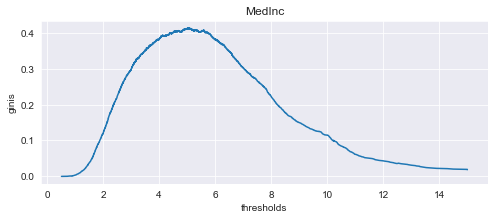

In [12]:
def plot_thresholds(thresholds, ginis, name):
    plt.figure(figsize=(8, 3))
    plt.xlabel("thresholds")
    plt.ylabel("ginis")
    plt.plot(thresholds, ginis)
    plt.title(name)
    plt.show()
plot_thresholds(thresholds, ginis, 'MedInc')

In [13]:
print('оптимальный порог:', threshold_best)
print('оптимальное значение критерия Джини:', gini_best)

оптимальный порог: 5.03515
оптимальное значение критерия Джини: 0.4127513862016769


Мы нашли оптимальное значение критерия Джини и соответсвующий оптимальный порог.

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [14]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

Для удобства сравнения изобразим все на одном, учитывая, что шкалы (множества значений) у каждого признака свои. По оси x отложены числа от 0 до количества порогов. Оптимальный порог по графику нельзя определить. (так делали на семинаре)

D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
D:\prog

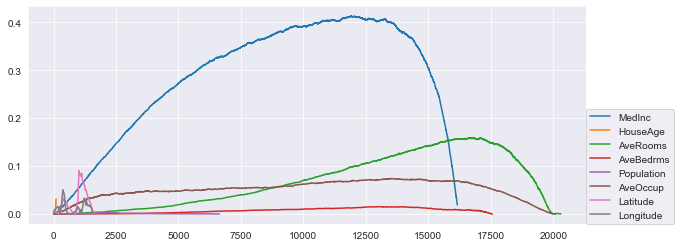

In [15]:
results = []
plt.figure(figsize=(10, 4))
for i in np.array(X.columns):
    thresholds, ginis, threshold_best, gini_best = find_best_split(np.array(X[str(i)]), np.array(y), task = 'regression', feature_type = 'real')
    plt.plot(np.arange(0, len(thresholds)), ginis, label = str(i))
    results.append((i, threshold_best, gini_best))
plt.legend(loc=(1, 0))
plt.show()

По графику наиболее подходящим признаком является MedInc. Посмотрим на оптимальные значения порогов и значений критерия Джини для всех признаков с помощью таблицы.

In [16]:
results = sorted(results, key=lambda x: x[2], reverse=True)
df = pd.DataFrame(results, columns=["feature", "optimal t", "optimal Q"])
df


,feature,optimal t,optimal Q
0,MedInc,5.035150,0.412751
1,AveRooms,6.374305,0.159208
2,Latitude,37.935000,0.090334
3,AveOccup,3.112543,0.073919
4,Longitude,-121.865000,0.050211
5,HouseAge,51.500000,0.030901
6,AveBedrms,1.103378,0.015253
7,Population,1160.500000,0.002831


Действительно, наибольшее значение критерия достигается при признаке MedInc: 0.412751. Построим график для него.

In [17]:
best = df.iloc[0]

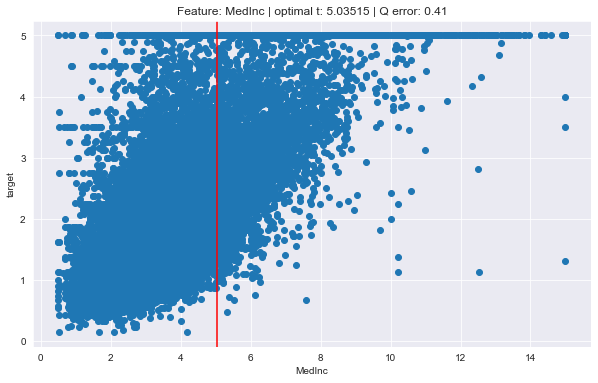

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(X[best.feature], y)
plt.axvline(x=best['optimal t'], color="red")
plt.xlabel(best.feature)
plt.ylabel("target")
plt.title("Feature: {} | optimal t: {} | Q error: {:.2f}".format(best.feature, best['optimal t'], best['optimal Q']))
plt.show()

Видно, что большинство точек слева от красной прямой принимаю значения <= 3, а справа от нее - больше. То есть разбиение можно назвать хорошим
P.S. использовались записи семинара 12

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [35]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        #print(type(sub_y[0]), type(sub_y))
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature not in self._feature_importances.keys():
                self._feature_importances[feature] = 0

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]
            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                self._feature_importances[feature] += gini_best

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split =  feature_vector <= threshold_best # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                else:
                    raise ValueError


        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        #print(node)

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        if node['type'] == 'terminal':
            return node['class']
        x_value = x[node['feature_split']]

        if 'threshold' in node.keys():
            thr = node['threshold']
            if x_value < thr:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])

        elif 'category_split' in node.keys():
            thr = node['category_split']
            if x_value == thr:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])

        #pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

    def feature_importances_(self):
        xc = list(self._feature_importances.values())
        return xc / sum(xc)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [36]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
#из семинара 13
data = pd.read_csv("students.csv")
data = data.drop(data.columns[0], axis = 1)
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\programs\anaconda3\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
D:\prog

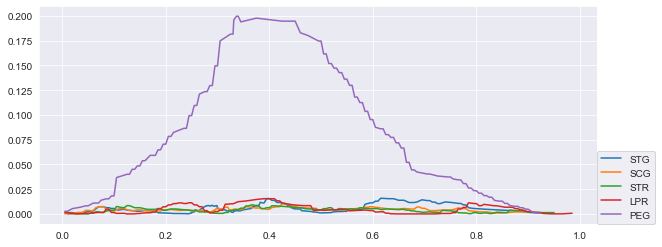

In [37]:
plt.figure(figsize=(10, 4))
for i in np.array(data.columns[:-1]):
    thresholds, ginis, threshold_best, gini_best = find_best_split(np.array(data[str(i)]), np.array(data['UNS']), task = 'regression', feature_type = 'real')
    plt.plot(thresholds, ginis, label = str(i))
plt.legend(loc=(1, 0))
plt.show()

Судя по графикам кривых "порог — значение критерия Джини", оптимальным признаком для разбиения является PEG, т.к. на нем достикается наивысшее значения критерия Джини.

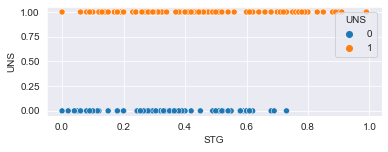

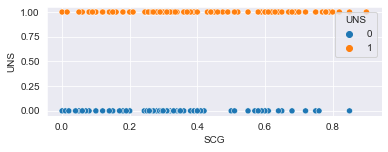

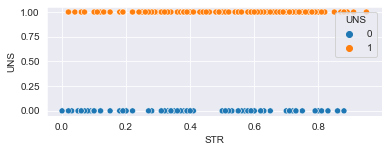

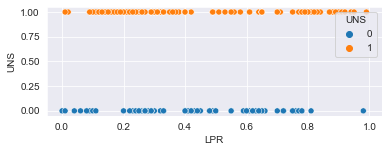

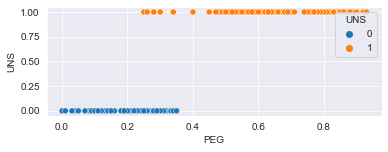

In [38]:
import seaborn as sns
for i in np.array(data.columns[:-1]):
    plt.figure(figsize=(6, 2))
    #plt.scatter(X[i], y)
    #plt.xlabel(i)
    #plt.ylabel("target")
    #plt.show()
    sns.scatterplot(data=data, x=i, y='UNS', hue = 'UNS')

По графикам рассеяния видно так же, что признак PEG позволяет наиболее четко разделить выборку: примерно при значении признака 0.35 выборка разделяется на классы.

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
Таким образом, разделение по признаку PEG является оптимальным. Это доказывают и графики рассеяния, и кривые значений критерия Джини. Результаты обоих видов графиков согласуются друг с другом. Вид кривой для "хороших" принаков имеет вид графика функции нормального распределения. Для "плохих" же признаков кривые приближаются к виду горизонтальной прямой, приближенной к 0.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [39]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
data = pd.read_csv('agaricus-lepiota.data')
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [40]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
le = preprocessing.LabelEncoder()
data = data.apply(lambda x: le.fit_transform(x))
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [53]:
x_train, x_test, y_train, y_test = train_test_split(
    data[data.columns[1:]], data[data.columns[0]], test_size=0.5, random_state=10000
)

In [54]:
d = DecisionTree(['categorical']*(x_train.columns).shape[0])
d.fit(np.array(x_train), np.array(y_train))


In [55]:
preds = d.predict(np.array(x_test))
print(sklearn.metrics.accuracy_score(np.array(y_test), preds))

0.9992614475627769


Получили очень высокую долю верных ответов!

In [58]:
d.feature_importances_()

array([0.09001912, 0.06165862, 0.07272723, 0.21600354, 0.21026947,
       0.        , 0.01395045, 0.15521247, 0.00826042, 0.        ,
       0.12933971, 0.        , 0.00805651, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03450245,
       0.        , 0.        ])

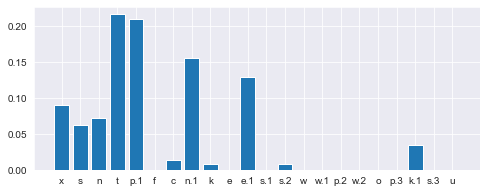

In [59]:
plt.figure(figsize=(8, 3))
plt.bar(x_train.columns, list(d.feature_importances_()))
plt.show()

Таким образом, мы видим, что многие признаки являются абсолютно неиформативными, распределение по ним совершенно не происходит.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [65]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [66]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

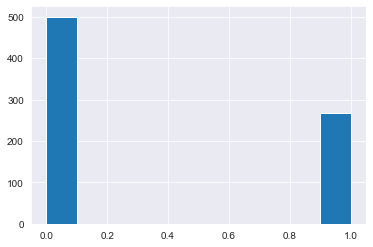

In [67]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [68]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)
x_traintr, x_valid, y_traintr, y_valid = train_test_split(
    x_train, y_train, test_size=0.3, random_state=123
)
print('соотношения: ', len(x_traintr) / len(X), len(x_valid) / len(X), len(x_test) / len(X))
print(len(x_train) / len(X))

соотношения:  0.48828125 0.2109375 0.30078125
0.69921875


Соотношения совпадают - выборка разделена верно.

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [69]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.metrics import f1_score
fones = {'params':[], 'f1':[]}
ff = [fones]
#1
depths = np.arange(1, 50, 2)
leaves = np.arange(1, 20)
#2
for max_depth in depths:
    for min_samples_leaf in leaves:
        trees = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        trees.fit(x_traintr, y_traintr)
        y_pred = trees.predict(x_valid)
        fones['params'].append((max_depth, min_samples_leaf))
        fones['f1'].append(f1_score(y_valid, y_pred))

In [70]:
#3
bests = fones['params'][np.argmax(fones['f1'])]
best_depth = bests[0]
best_leaves = bests[1]
print('best f1:', max(fones['f1']), '\noptinmal depth and leaves:', bests)

best f1: 0.616822429906542 
optinmal depth and leaves: (3, 1)


In [71]:
tree = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_leaves)
tree.fit(x_train, y_train)
y_preds = tree.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_preds))
print('precision:', precision_score(y_test, y_preds))
print('recall:', recall_score(y_test, y_preds))
print('auc-roc:', roc_auc_score(y_test, y_preds))
print('f1:', f1_score(y_test, y_preds))

accuracy: 0.7229437229437229
precision: 0.8529411764705882
recall: 0.32954545454545453
auc-roc: 0.6472902097902097
f1: 0.4754098360655738


Таким образом, были подобраны оптимальные гиперпараметры для модели. Высокие метрики являются этому подтверждением.

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [72]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
b = BaggingClassifier(n_estimators=50)
b.fit(x_train, y_train)
y_preds = b.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_preds))
print('precision:', precision_score(y_test, y_preds))
print('recall:', recall_score(y_test, y_preds))
print('auc-roc:', roc_auc_score(y_test, y_preds))
print('f1:', f1_score(y_test, y_preds))

accuracy: 0.7705627705627706
precision: 0.7011494252873564
recall: 0.6931818181818182
auc-roc: 0.7556818181818182
f1: 0.6971428571428572


Можно заметить, что качество улучшилось относительно ранее обученного дерева. Только немного уменьшилась точность precision

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [73]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
#source for cross_val: https://stackoverflow.com/questions/46598301/how-to-compute-precision-recall-and-f1-score-of-an-imbalanced-dataset-for-k-fold
from sklearn.model_selection import cross_val_score
#1
depths = np.arange(1, 30, 2)
leaves = np.arange(1, 20)
fones = {'params':[], 'f1':[]}
#2
for max_depth in depths:
    for min_samples_leaf in leaves:
        trees = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        fones['params'].append((max_depth, min_samples_leaf))
        fones['f1'].append(cross_val_score(trees, x_train, y_train, scoring = 'f1').mean())


In [74]:
#3
bests = fones['params'][np.argmax(fones['f1'])]
best_depth = bests[0]
best_leaves = bests[1]
print('best f1:', max(fones['f1']), '\noptinmal depth and leaves:', bests)

best f1: 0.6315511621893285 
optinmal depth and leaves: (19, 5)


In [75]:
rf = RandomForestClassifier(n_estimators=50, max_depth=best_depth, min_samples_leaf=best_leaves)
rf.fit(x_train, y_train)
y_preds = rf.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_preds))
print('precision:', precision_score(y_test, y_preds))
print('recall:', recall_score(y_test, y_preds))
print('auc-roc:', roc_auc_score(y_test, y_preds))
print('f1:', f1_score(y_test, y_preds))

accuracy: 0.7748917748917749
precision: 0.7368421052631579
recall: 0.6363636363636364
auc-roc: 0.7482517482517481
f1: 0.6829268292682926


С уверенностью можно сказать, что Bagging и RandomForest делают предсказания качественнее DecisionTree. Это так, посколку увеличивается устойчивость модели. Лучший результат по большинтву метрик показал random forest. Это обосновывается тем, что этот метод делает деревья менее похожими друг на друга. (при разных random_state - разные результаты. Иногда Bagging показывает лучший результат относительно случайного леса.)

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [76]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.metrics import roc_curve, roc_auc_score
fones = {'params':[], 'roc':[]}
for n in range(1, 300):
    t = RandomForestClassifier(n_estimators=n)
    t.fit(x_train, y_train)
    fones['params'].append(n)
    fones['roc'].append(roc_auc_score(y_test, t.predict(x_test)))


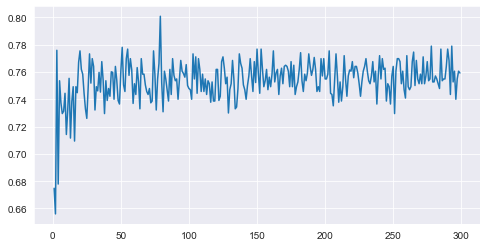

In [77]:
plt.figure(figsize=(8, 4))
plt.plot(fones['params'], fones['roc'])
plt.show()

In [78]:
max(fones['roc'])

0.8006993006993007

Можно увидеть, что до значения примерно 40 auc roc возрастает. Затем оно в среднем держится примерно на одном уровне. Это характерно для случ. леса, его невозможно переобучить. Всегда при увеличении числа деревьев ошибка сначала убывает, а потом не меняется. Максимальное значение площади под кривой ROC - около 0.78453.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

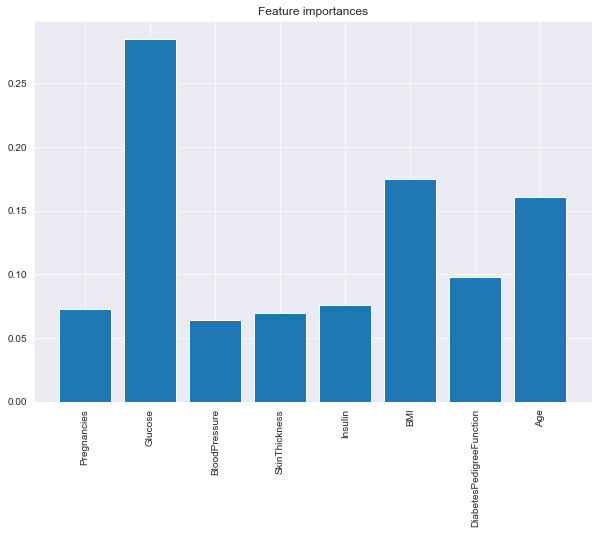

In [79]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(data.columns[:-1].tolist(), rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Самым выжным оказался признак glucose. Это похоже на реальную зависимость (в жизни).